# Question 1

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

In [2]:
root = './A2_resources/'

In [3]:
def read(path, arg = cv2.IMREAD_UNCHANGED):
    args = {'gray' : cv2.IMREAD_GRAYSCALE, 'unchanged' : cv2.IMREAD_UNCHANGED, 'color' : cv2.IMREAD_COLOR}
    return cv2.imread(path, args[arg])

## Part 1 Canny Edge Detector 

### bell.jpg

In [4]:
im = read(root+'bell.jpg', 'color')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

> The threshold values $(minVal, maxVal) = (50, 190)$ gives good results for bell.jpg with L1 gradient

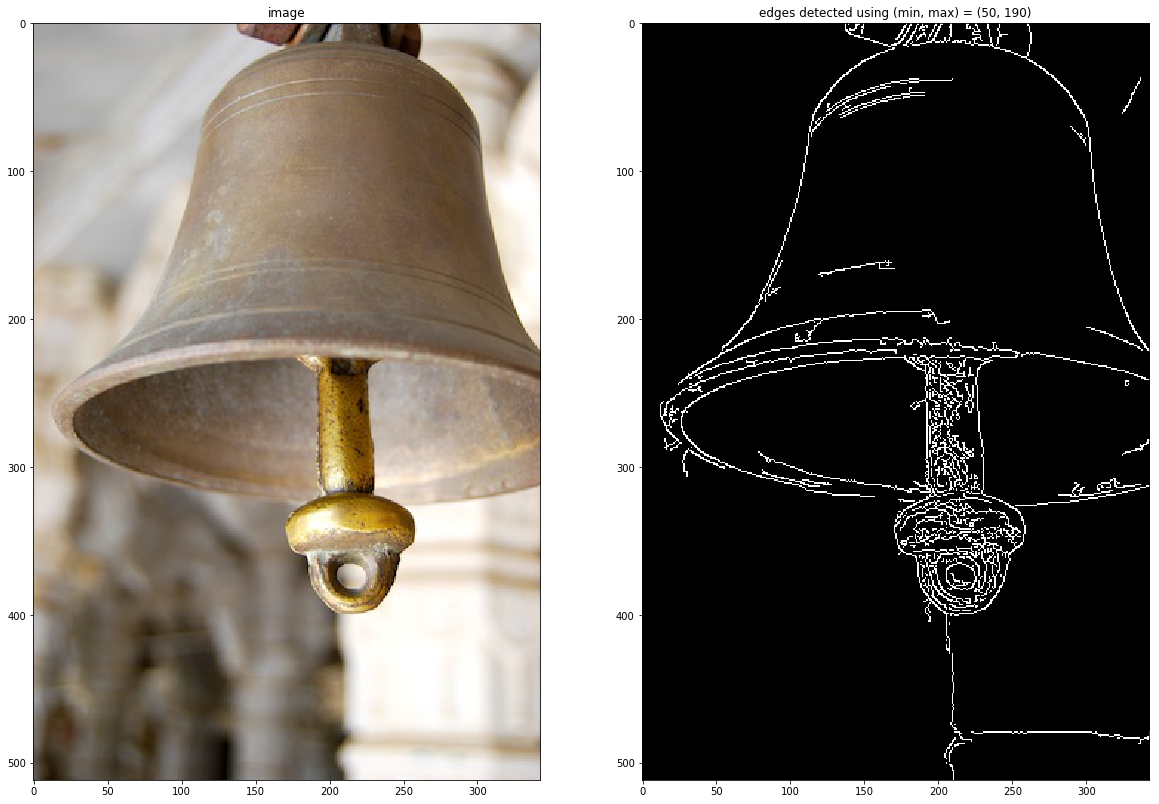

In [5]:
#using otsu thresholding (works best for bimodal images)
# ret,th = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# out = cv2.Canny(im, ret*(0.33), ret, L2gradient = True)

out = cv2.Canny(im, 50, 190, L2gradient = False)
_, plots = plt.subplots(1,2,figsize = (20,20))
plots[0].imshow(im)
plots[0].set_title("image")
plots[1].imshow(out, cmap = 'gray', vmin = 0, vmax = 255)
plots[1].set_title("edges detected using (min, max) = (50, 190)")

plt.show()

### cubes.png

In [6]:
im = read(root+'cubes.png', 'color')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

> The threshold values $(minVal, maxVal) = (55, 190)$ gives good results for cubes.png with L1 gradient

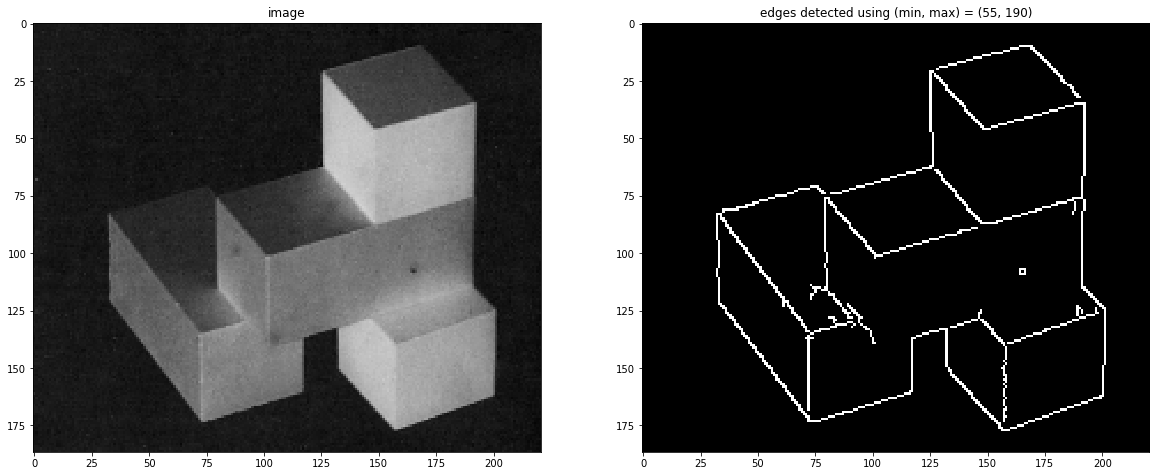

In [7]:
#using otsu thresholding (works best for bimodal images)
# ret,th = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# out = cv2.Canny(im, ret*(0.33), ret, L2gradient = True)

out = cv2.Canny(im, 55, 190, L2gradient = False)

_, plots = plt.subplots(1,2,figsize = (20,20))
plots[0].imshow(im)
plots[0].set_title("image")
plots[1].imshow(out, cmap = 'gray', vmin = 0, vmax = 255)
plots[1].set_title("edges detected using (min, max) = (55, 190)")


plt.show()

## Part 2

- Prewitt

In [8]:
fPrewit = np.asarray([np.asarray([[-1,0,1],[-1,0,1],[-1,0,1]]),np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])])

- Sobel

In [9]:
fSobel = np.asarray([np.asarray([[-1,0,1],[-2,0,2],[-1,0,1]]),np.asarray([[1,2,1],[0,0,0],[-1,-2,-1]])])

- Roberts

In [10]:
fRobert = np.asarray([np.asarray([[0,1],[-1,0]]),np.asarray([[1,0],[0,-1]])])

- Laplacian

In [11]:
fLap = np.asarray([np.asarray([[0,1,0],[1,-4,1],[0,1,0]])])

- Laplacian diagonal

In [12]:
fLapdiag = np.asarray([np.asarray([[1,1,1],[1,-8,1],[1,1,1]])])

In [13]:
def strided(img, kernel):
    img = img.astype('float32')
    img = np.pad(img, (np.int16((kernel.shape[0]-1)/2), np.int16((kernel.shape[1]-1)/2)), 'reflect')
    expanded_input = np.lib.stride_tricks.as_strided(
    img,
    shape=(
        img.shape[0] - kernel.shape[0] + 1,
        img.shape[1] - kernel.shape[1] + 1,
        kernel.shape[0],
        kernel.shape[1],
    ),
    strides=(
        img.strides[0],
        img.strides[1],
        img.strides[0],
        img.strides[1],
    )
)
    return expanded_input

In [14]:
def conv2d(img, kernel):

    channels = 1
    if len(img.shape) > 2:
        channels = img.shape[2]

    if channels == 1:
        return np.tensordot(strided(img, kernel), kernel)
    else:
        res = np.tensordot(strided(img[:,:,0], kernel), kernel)
        for i in range(1,channels):
            res = np.dstack((res, np.tensordot(strided(img[:,:,i], kernel), kernel)))
        return res

In [15]:
def applyFilter(img, kernel, layers = 1):
    res = np.power(conv2d(img, kernel[0]),2)
    for i in range(1,layers):
        res = res + np.power(conv2d(img, kernel[i]),2)
    return np.uint8(np.round(np.power(res, 0.5)))

### Applying filter on barabara.jpg

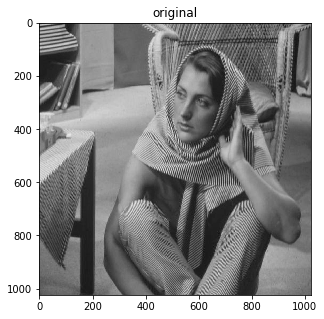

In [16]:
im = read(root+'barbara.jpg', 'gray')
plt.figure(figsize = (5,5))
plt.imshow(im, cmap = 'gray', vmin = 0, vmax = 255)
plt.title('original')
plt.show()

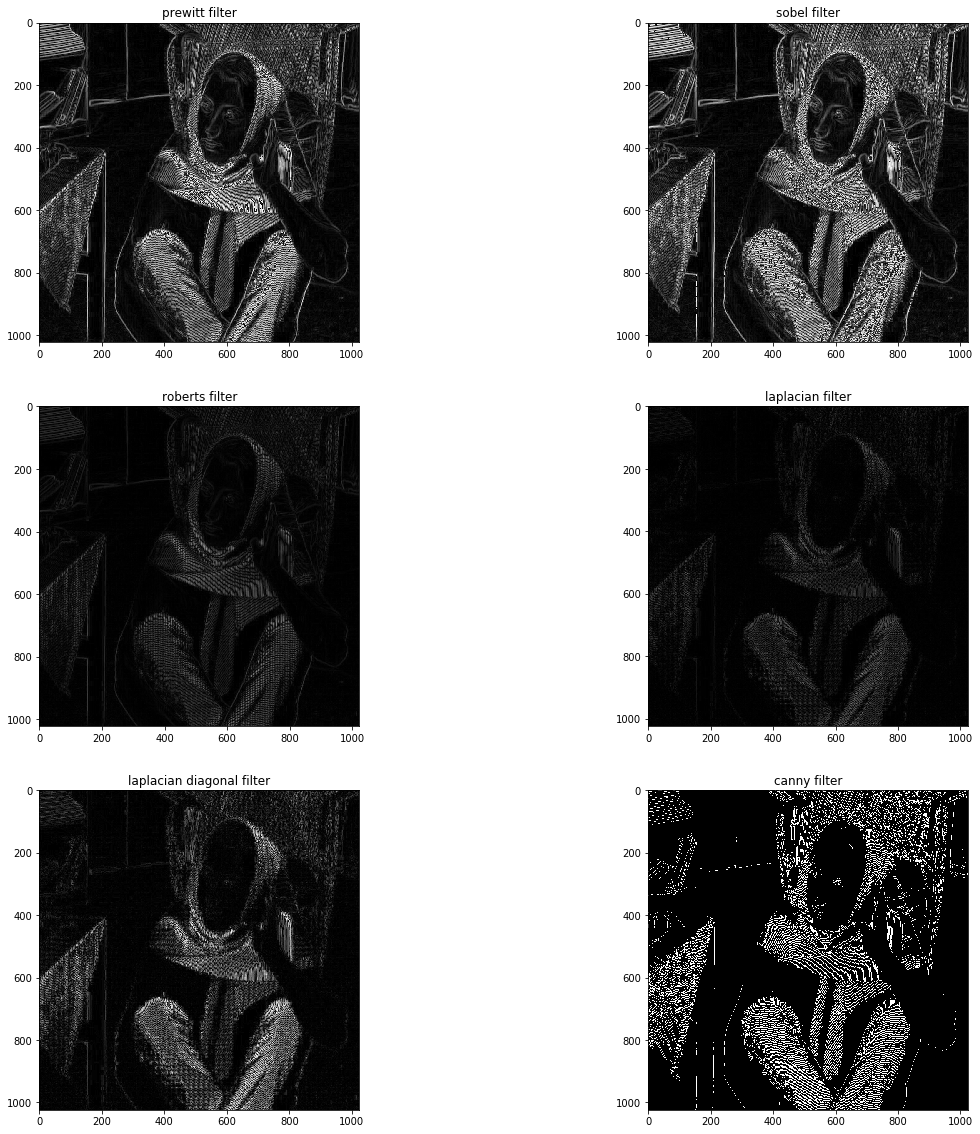

In [17]:
_,plots = plt.subplots(3,2,figsize = (20,20))
plots[0][0].imshow(applyFilter(im, fPrewit, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[0][0].set_title('prewitt filter')
plots[0][1].imshow(applyFilter(im, fSobel, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[0][1].set_title('sobel filter')
plots[1][0].imshow(applyFilter(im, fRobert, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[1][0].set_title('roberts filter')
plots[1][1].imshow(applyFilter(im, fLap, 1), cmap = 'gray', vmin = 0, vmax = 255)
plots[1][1].set_title('laplacian filter')
plots[2][0].imshow(applyFilter(im, fLapdiag, 1), cmap = 'gray', vmin = 0, vmax = 255)
plots[2][0].set_title('laplacian diagonal filter')
plots[2][1].imshow(cv2.Canny(im, 50, 140, L2gradient = False), cmap = 'gray', vmin = 0, vmax = 255)
plots[2][1].set_title('canny filter')
plt.show()

### Observations
- Canny edge detector gives good results with appropriate threshold values as it also considers the neighbourhood for detecting and edge. If the value of pixel is greater than lower threshold but lower than upper threshold, then it will be considered an edge pixel only if it is connected to an edge pixel
- Prewitt and sobel filters give good results as they take account of gradient in both x and y directions. Sobel gives good results as more weightage is given to directly connected pixels whie calculating gradient.
- Laplacian shows very less prominnet results.
- Roberts filter is very less computationaly expensive as the kernel is 2x2.

## Part 3
### Applying filter on barabara.jpg with gaussian noise added

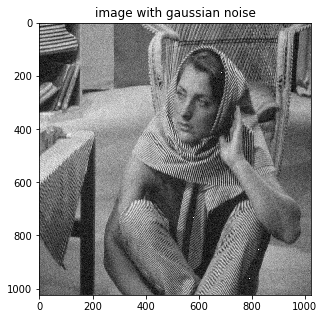

In [18]:
im = read(root+'barbara.jpg', 'gray')
noise = np.random.normal(loc = 0, scale = 10, size = im.shape)
im = np.uint8(im+noise)
plt.figure(figsize=(5,5))
plt.imshow(im, cmap = 'gray', vmin = 0, vmax = 255)
plt.title('image with gaussian noise')
plt.show()

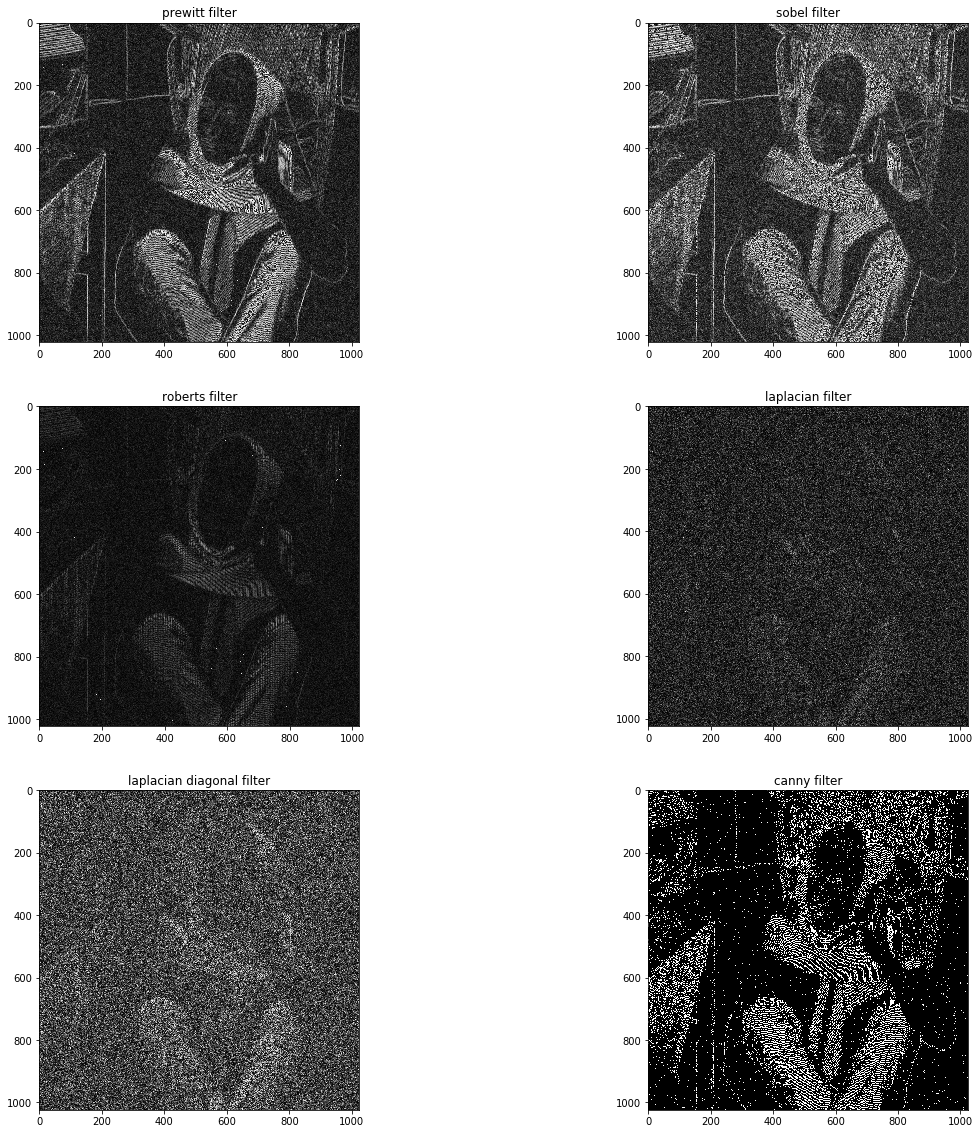

In [19]:
_,plots = plt.subplots(3,2,figsize = (20,20))
plots[0][0].imshow(applyFilter(im, fPrewit, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[0][0].set_title('prewitt filter')
plots[0][1].imshow(applyFilter(im, fSobel, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[0][1].set_title('sobel filter')
plots[1][0].imshow(applyFilter(im, fRobert, 2), cmap = 'gray', vmin = 0, vmax = 255)
plots[1][0].set_title('roberts filter')
plots[1][1].imshow(applyFilter(im, fLap, 1), cmap = 'gray', vmin = 0, vmax = 255)
plots[1][1].set_title('laplacian filter')
plots[2][0].imshow(applyFilter(im, fLapdiag, 1), cmap = 'gray', vmin = 0, vmax = 255)
plots[2][0].set_title('laplacian diagonal filter')
plots[2][1].imshow(cv2.Canny(im, 120, 140, L2gradient = False), cmap = 'gray', vmin = 0, vmax = 255)
plots[2][1].set_title('canny filter')

plt.show()

### Observations

> When gaussian noise is added to the image,
- Performance of canny detector depends on the threshold values given. If higher value is given to lower threshold then wrongly detected edges are not taken.
- Laplacian performs poorly as it gives the differnce between the values of the pixel and its neighbourhood. So if the neighbourhood has noise then it can give wrong values. Hence the edges may be calculated incorrectly.
- Prewitt, Sobel and Roberts are not affected as much as others bt the noise because they calcuate the gradient in x and y directions and then take l2 or l1 norm. So it very unlikely that when there is an edge and it is not detected as gradient in both x and y directions are calculated individually